<a href="https://colab.research.google.com/github/sujit-j/Deep-Learning/blob/main/MusicGenreIdentification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import os
import pandas as pd
from glob import glob
import numpy as np

In [3]:
!wget https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0

--2021-07-18 09:51:19--  https://www.dropbox.com/s/4jw31k5mlzcmgis/genres.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/4jw31k5mlzcmgis/genres.tar.gz [following]
--2021-07-18 09:51:20--  https://www.dropbox.com/s/raw/4jw31k5mlzcmgis/genres.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucde386e19e7df180f36f3474d1a.dl.dropboxusercontent.com/cd/0/inline/BSjC7rD9J3f_TPwvS3K0kUJ1sq4XvYFoPHNxs9Pj-UVLcg8bgeqRVxw7F1RZVpv4ECxOSaeRVFtiH9vkzT4D6qr9aUkxytriK8CRSsS1yDiXvodz4TUNuMPCU-AJOv2sP8APBEK1IQHVgm8moZMrpmiF/file# [following]
--2021-07-18 09:51:20--  https://ucde386e19e7df180f36f3474d1a.dl.dropboxusercontent.com/cd/0/inline/BSjC7rD9J3f_TPwvS3K0kUJ1sq4XvYFoPHNxs9Pj-UVLcg8bgeqRVxw7F1RZVpv4ECxOSaeRVFtiH9vkz

In [4]:
import tarfile

In [5]:
data = tarfile.open("genres.tar.gz?dl=0")

In [6]:
data.extractall('./Audiodata')

In [7]:
data.close()

In [8]:
!pip install path

In [9]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
from path import Path

In [10]:
import os
os.mkdir('train')
os.mkdir('test')

In [11]:
def create_spectrogram(filename,name):
    plt.interactive(False)
    clip, sample_rate = librosa.load(filename, sr=None)
    fig = plt.figure(figsize=[0.72,0.72])
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    S = librosa.feature.melspectrogram(y=clip, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
    filename  = '/content/train/' + name + '.jpg'
    plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
    plt.close()    
    fig.clf()
    plt.close(fig)
    plt.close('all')
    del filename,name,clip,sample_rate,fig,ax,S

In [12]:
glob('./train/*')

[]

In [13]:
file_list=list(glob("./Audiodata/genres/blues/*"))

In [14]:
# for i,file in enumerate(file_list):
#     print(i)
#     filename,name = file,file.split('.')[0]
#     create_spectrogram(filename,name)

In [15]:
import IPython.display as ipd

In [16]:
genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']

In [17]:
audio_fpath = "/content/Audiodata/genres/blues/"
audio_clips = os.listdir(audio_fpath)

# audio_fpath = "/content/Audiodata/genres/blues/"
# audio_clips_blues = os.listdir(audio_fpath)

print("No. of .wav files in audio folder = ",len(audio_clips))

No. of .wav files in audio folder =  100


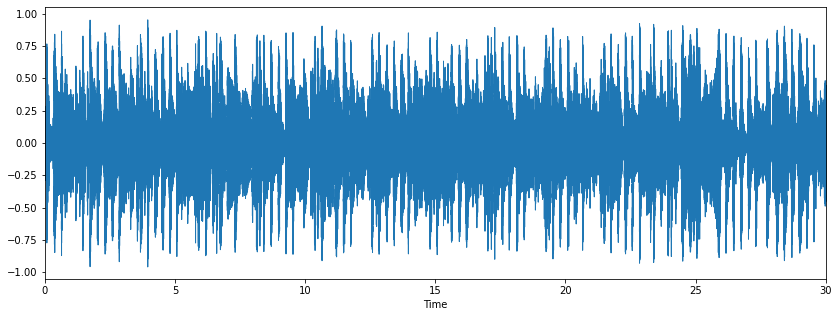

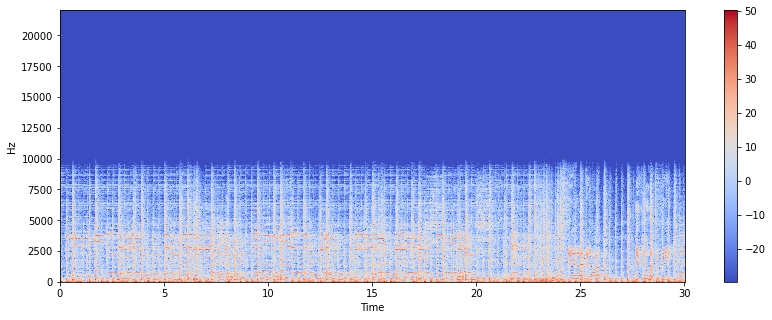

In [18]:
x, sr = librosa.load(audio_fpath+audio_clips[2], sr=44100)
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

In [19]:
os.getcwd()
os.listdir()

['.config', 'test', 'train', 'genres.tar.gz?dl=0', 'Audiodata', 'sample_data']

In [20]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [21]:
import csv
file = open('data.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
for g in genres:
    for filename in os.listdir(f'./Audiodata/genres/{g}'):
        songname = f'./Audiodata/genres/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=30)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)[0]
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{filename} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('data.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
data = pd.read_csv('data.csv')
data = data.drop(['filename'],axis=1)
data.head()

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,0.466436,0.192154,2225.216647,2255.195005,4703.188227,0.108587,-86.352333,92.675247,-15.377407,54.059780,0.883209,31.563927,-14.615397,23.320065,-14.975420,15.335824,-7.047202,12.181272,-6.097624,7.025419,-5.805348,7.432127,-6.075142,3.382991,-4.276934,1.238193,blues
1,0.321085,0.101159,1046.748840,1480.933764,1830.788929,0.047937,-264.698395,138.855972,11.186485,48.520340,14.915178,20.572824,3.207815,1.247171,-15.846408,15.986909,3.368814,-1.520129,1.894727,6.325552,-0.986607,-2.412859,-3.683062,0.496946,5.046816,-0.780010,blues
2,0.405961,0.169987,2235.906952,2100.004335,4390.031787,0.142288,-86.225304,91.948448,-23.408659,68.253288,-3.895873,22.745262,-9.899613,16.895977,-11.397530,18.431677,-7.015264,10.771055,-11.938685,1.005814,-5.923496,5.318165,-6.140525,1.948991,-5.102755,-0.666248,blues
3,0.302732,0.075387,1389.955510,1911.485152,3005.773491,0.052560,-230.412994,127.094185,7.151100,39.782089,1.951132,17.411690,-5.625576,8.252521,-18.105352,13.839342,-3.763585,2.561243,-4.329453,6.817760,-6.157660,-6.214757,-4.515434,-1.850599,-0.539056,1.508026,blues
4,0.380260,0.248262,2116.942959,1956.611056,4196.107960,0.127272,-26.929785,107.334015,-46.809990,40.932632,-21.463776,24.816273,-18.945572,15.253460,-15.050104,12.262822,-15.234052,14.336612,-13.821767,7.562789,-6.181373,0.330165,-6.829571,0.965922,-7.570825,2.918987,blues


In [23]:
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [24]:
scaler = StandardScaler()
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train

array([8, 1, 6, 0, 2, 6, 4, 8, 6, 0, 9, 6, 7, 1, 5, 8, 3, 0, 4, 9, 3, 3,
       9, 2, 9, 9, 4, 7, 8, 8, 6, 3, 5, 3, 4, 8, 5, 6, 9, 9, 4, 4, 9, 4,
       5, 0, 5, 3, 8, 8, 4, 0, 0, 6, 7, 3, 8, 2, 1, 8, 6, 8, 0, 6, 3, 5,
       9, 9, 4, 6, 3, 5, 9, 0, 2, 2, 7, 2, 6, 6, 4, 1, 5, 1, 5, 7, 8, 1,
       8, 8, 6, 6, 3, 3, 7, 6, 7, 5, 0, 7, 7, 1, 3, 5, 2, 2, 1, 2, 1, 5,
       4, 7, 4, 1, 3, 1, 4, 7, 0, 0, 6, 1, 0, 9, 9, 0, 2, 9, 5, 2, 0, 0,
       7, 9, 7, 9, 2, 6, 8, 9, 2, 5, 7, 7, 4, 7, 0, 3, 6, 6, 7, 6, 7, 9,
       5, 2, 2, 0, 9, 0, 9, 5, 5, 5, 2, 9, 1, 5, 9, 4, 3, 9, 2, 4, 0, 7,
       1, 5, 7, 6, 4, 9, 8, 0, 3, 2, 4, 1, 8, 1, 6, 5, 9, 6, 4, 4, 0, 3,
       1, 1, 2, 1, 5, 1, 7, 0, 2, 4, 3, 5, 9, 8, 3, 9, 9, 8, 9, 3, 1, 5,
       3, 2, 7, 2, 3, 9, 7, 0, 1, 9, 0, 3, 4, 9, 9, 7, 5, 8, 6, 3, 6, 2,
       3, 1, 9, 5, 3, 5, 6, 2, 7, 0, 1, 2, 2, 2, 2, 8, 6, 5, 6, 7, 9, 9,
       5, 4, 5, 0, 5, 6, 8, 4, 5, 6, 4, 2, 6, 8, 9, 4, 1, 3, 5, 5, 2, 2,
       3, 7, 5, 4, 3, 8, 8, 9, 4, 0, 8, 2, 4, 2, 1,

In [26]:
from tensorflow.keras.layers import Dense, Activation
model_ann = models.Sequential()
model_ann.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model_ann.add(layers.Dense(128, activation='relu'))
model_ann.add(layers.Dense(64, activation='relu'))
model_ann.add(layers.Dense(10, activation='softmax'))
X_train.shape[1]

26

In [27]:
model_ann.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
print("Fit model on training data")
history = model_ann.fit(
    X_train,
    y_train,
    batch_size=128,
    epochs=20
)

Fit model on training data
Epoch 1/20
7/7 [==============================] - 1s 5ms/step - loss: 2.1907 - accuracy: 0.2138
Epoch 2/20
7/7 [==============================] - 0s 3ms/step - loss: 1.8957 - accuracy: 0.3413
Epoch 3/20
7/7 [==============================] - 0s 3ms/step - loss: 1.6958 - accuracy: 0.4050
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 1.5169 - accuracy: 0.4625
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 1.3701 - accuracy: 0.5088
Epoch 6/20
7/7 [==============================] - 0s 3ms/step - loss: 1.2520 - accuracy: 0.5700
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 1.1434 - accuracy: 0.6237
Epoch 8/20
7/7 [==============================] - 0s 5ms/step - loss: 1.0560 - accuracy: 0.6475
Epoch 9/20
7/7 [==============================] - 0s 3ms/step - loss: 0.9982 - accuracy: 0.6662
Epoch 10/20
7/7 [==============================] - 0s 4ms/step - loss: 0.9278 - accuracy: 0.7050
Epoch 11/20


In [29]:
test_loss, test_acc = model_ann.evaluate(X_test,y_test)
print('test_acc: ',test_acc)
print('test_loss: ',test_loss)

7/7 [==============================] - 0s 2ms/step - loss: 1.0753 - accuracy: 0.6100
test_acc:  0.6100000143051147
test_loss:  1.0753226280212402


In [30]:
predictions = model_ann.predict(X_test)
# np.argmax(predictions[0])
print("Predicted : " ,predictions[0])
print("Actual : ",y_test[0])

Predicted :  [2.0923966e-03 4.5182002e-01 1.4875242e-03 7.8167691e-04 1.6662014e-04
 5.4198110e-01 5.4487055e-06 3.3208233e-04 1.0824818e-03 2.5063471e-04]
Actual :  5
